## Objective of the competition
To forecast the short term returns (15 minute residualized returns) in 14 popular cryptocurrencies.
    
## Introduction
Cryptocurrency markets are very volatile in nature and has high trading volumes. It is also open 24 * 7 unlike traditional capital markets. This means we can get a continuous flow of data which will be super helpful for time series forecasting. On the other hand, most of the cryptocurrencies do not have the so called underlying fundamentals data and so most of the price movements are driven by technical indicators and market sentiments. This makes it one of the best play grounds for traders to make huge gains (and losses!).

In this competition, we will be looking at 14 cryptocurrencies and predict the short term price movements of them. We will be using a time-series API that will help us from looking into the future data (try not to play around it :)) and make predictions.

## Data
We are given the training file `train.csv` with the following columns 

* timestamp - A timestamp for the minute covered by the row.
* Asset_ID - An ID code for the cryptoasset.
* Count - The number of trades that took place this minute.
* Open - The USD price at the beginning of the minute.
* High - The highest USD price during the minute.
* Low - The lowest USD price during the minute.
* Close - The USD price at the end of the minute.
* Volume - The number of cryptoasset units traded during the minute.
* VWAP - The volume weighted average price for the minute.
* Target - 15 minute residualized returns. 

We are given only 14 cryptocurrencies / assets for this competition. Let us look at them in detail.

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
cmap = sns.color_palette()

competition_data_path = "../input/g-research-crypto-forecasting/"

## Assets Data Exploration

In [2]:
assets_df = pd.read_csv(os.path.join(competition_data_path, "asset_details.csv"))
assets_df.sort_values("Weight", ascending=False)

,Asset_ID,Weight,Asset_Name
2,1,6.779922,Bitcoin
5,6,5.894403,Ethereum
10,3,4.406719,Cardano
1,0,4.304065,Binance Coin
13,4,3.555348,Dogecoin
0,2,2.397895,Bitcoin Cash
6,9,2.397895,Litecoin
4,7,2.079442,Ethereum Classic
9,12,2.079442,Stellar
8,13,1.791759,TRON


We see that the top cryptocurrencies are given for this competition including bitcoin, ethereum, binance coin etc. Also, we can see the weights column that will be used to get the `weighted pearson correlation coefficient` evaluation metric.

Let us see the sum of the weights to see if they add up to 100.

In [3]:
assets_df["Weight"].sum()

40.879847092769616

Looks like the weights add up to `40.88`. Not sure of the exact reason. Let us see the percentage of weights given to each of the assets now. 

In [4]:
assets_df["weight_percentage"] = (assets_df["Weight"] / assets_df["Weight"].sum()) * 100
assets_df.sort_values("Weight", ascending=False)

,Asset_ID,Weight,Asset_Name,weight_percentage
2,1,6.779922,Bitcoin,16.584998
5,6,5.894403,Ethereum,14.418848
10,3,4.406719,Cardano,10.779686
1,0,4.304065,Binance Coin,10.528574
13,4,3.555348,Dogecoin,8.697068
0,2,2.397895,Bitcoin Cash,5.865715
6,9,2.397895,Litecoin,5.865715
4,7,2.079442,Ethereum Classic,5.086716
9,12,2.079442,Stellar,5.086716
8,13,1.791759,TRON,4.382990


In [5]:
fig = px.pie(assets_df, values='weight_percentage', names='Asset_Name', title='Weights given to each cryptocurrency')
fig.show()

## Training Data Exploration

Let us look at the top few rows of the data to start with.

In [6]:
crypto_df = pd.read_csv(os.path.join(competition_data_path, "train.csv"))
print(f"There are {crypto_df.shape[0]} rows in the given dataset")
crypto_df.head()

There are 24236806 rows in the given dataset


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


### Start & End Time
Let us now look at the start and end time of each of the given crypto currencies.

In [7]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in assets_df.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

time_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    start_time = coin_df.index[0].astype('datetime64[s]')
    end_time = coin_df.index[-1].astype('datetime64[s]')
    time_list.append([coin, start_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Start_Time", "End_Time"]
time_df

,Asset_Name,Start_Time,End_Time
0,Bitcoin,2018-01-01 00:01:00,2021-09-21
1,Ethereum,2018-01-01 00:01:00,2021-09-21
2,Cardano,2018-04-17 09:11:00,2021-09-21
3,Binance Coin,2018-01-01 00:01:00,2021-09-21
4,Dogecoin,2019-04-12 14:34:00,2021-09-21
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-21
6,Litecoin,2018-01-01 00:01:00,2021-09-21
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-21
8,Stellar,2018-02-16 23:53:00,2021-09-21
9,TRON,2018-02-06 21:37:00,2021-09-21


**Inference:**
* The earliest start date in the data is Jan 1, 2018 and most coins have that start datetime.
* The data is available till Sep 21, 2021 and all the coins have the same end datetime.
* Dogecoin has the least historical information available of the given coins and is captured onlt from April 2019. 

### Missing data

Now let us check the missing data in each of these assets / coins.

In [8]:
missing_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist())
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']
missing_df

,Asset_Name,TotalRows,Missing_Asset_ID,Missing_Count,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume,Missing_VWAP,Missing_Target
0,Bitcoin,1956282,0,0,0,0,0,0,0,0,304
1,Ethereum,1956200,0,0,0,0,0,0,0,0,340
2,Cardano,1791867,0,0,0,0,0,0,0,0,18731
3,Binance Coin,1942619,0,0,0,0,0,0,0,0,13415
4,Dogecoin,1156866,0,0,0,0,0,0,0,0,144974
5,Bitcoin Cash,1953537,0,0,0,0,0,0,0,0,4861
6,Litecoin,1956030,0,0,0,0,0,0,0,0,521
7,Ethereum Classic,1951127,0,0,0,0,0,0,0,0,9326
8,Stellar,1778749,0,0,0,0,0,0,0,0,61816
9,TRON,1874560,0,0,0,0,0,0,0,0,21014


**Inference:**
* There is a lot of missing data in the Target column
* All the other columns do not have missing data
* Bitcoin has the least number of missing target values and Monero the most.
* We need to deal with these missing target values carefully.

### Gaps

It is also mentioned in the competition that missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. So let us check the gaps in the data. 

We know that the data is collected once every 60 seconds. If we have a gap of more than one minute between consecutive rows, then it indicates that the data is missing in between. Let us check that for each of the coins.

In [9]:
gap_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index()
    n_gaps = gap_df[gap_df["index"]!=60]["timestamp"].sum()
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df

,Asset_Name,number_of_gaps,max_gap_in_seconds
0,Bitcoin,145,2400
1,Ethereum,156,7200
2,Cardano,9360,4800
3,Binance Coin,6600,120720
4,Dogecoin,76652,7260
5,Bitcoin Cash,2502,4380
6,Litecoin,291,5280
7,Ethereum Classic,4707,3780
8,Stellar,37770,8520
9,TRON,12225,3000


**Inference:**
* There are several gaps in the dataset and we need to treat them carefully
* Maker coin has the maximum gap of 281700 seconds or about 78 hours
* When we have gaps in the data, we can't compute the returns for the time period that comes just after these gaps. I think that is the reason we have missing target values in our data. 

### Visualization

Now let us visualize the training data and see how the prices of the coins varied over time.

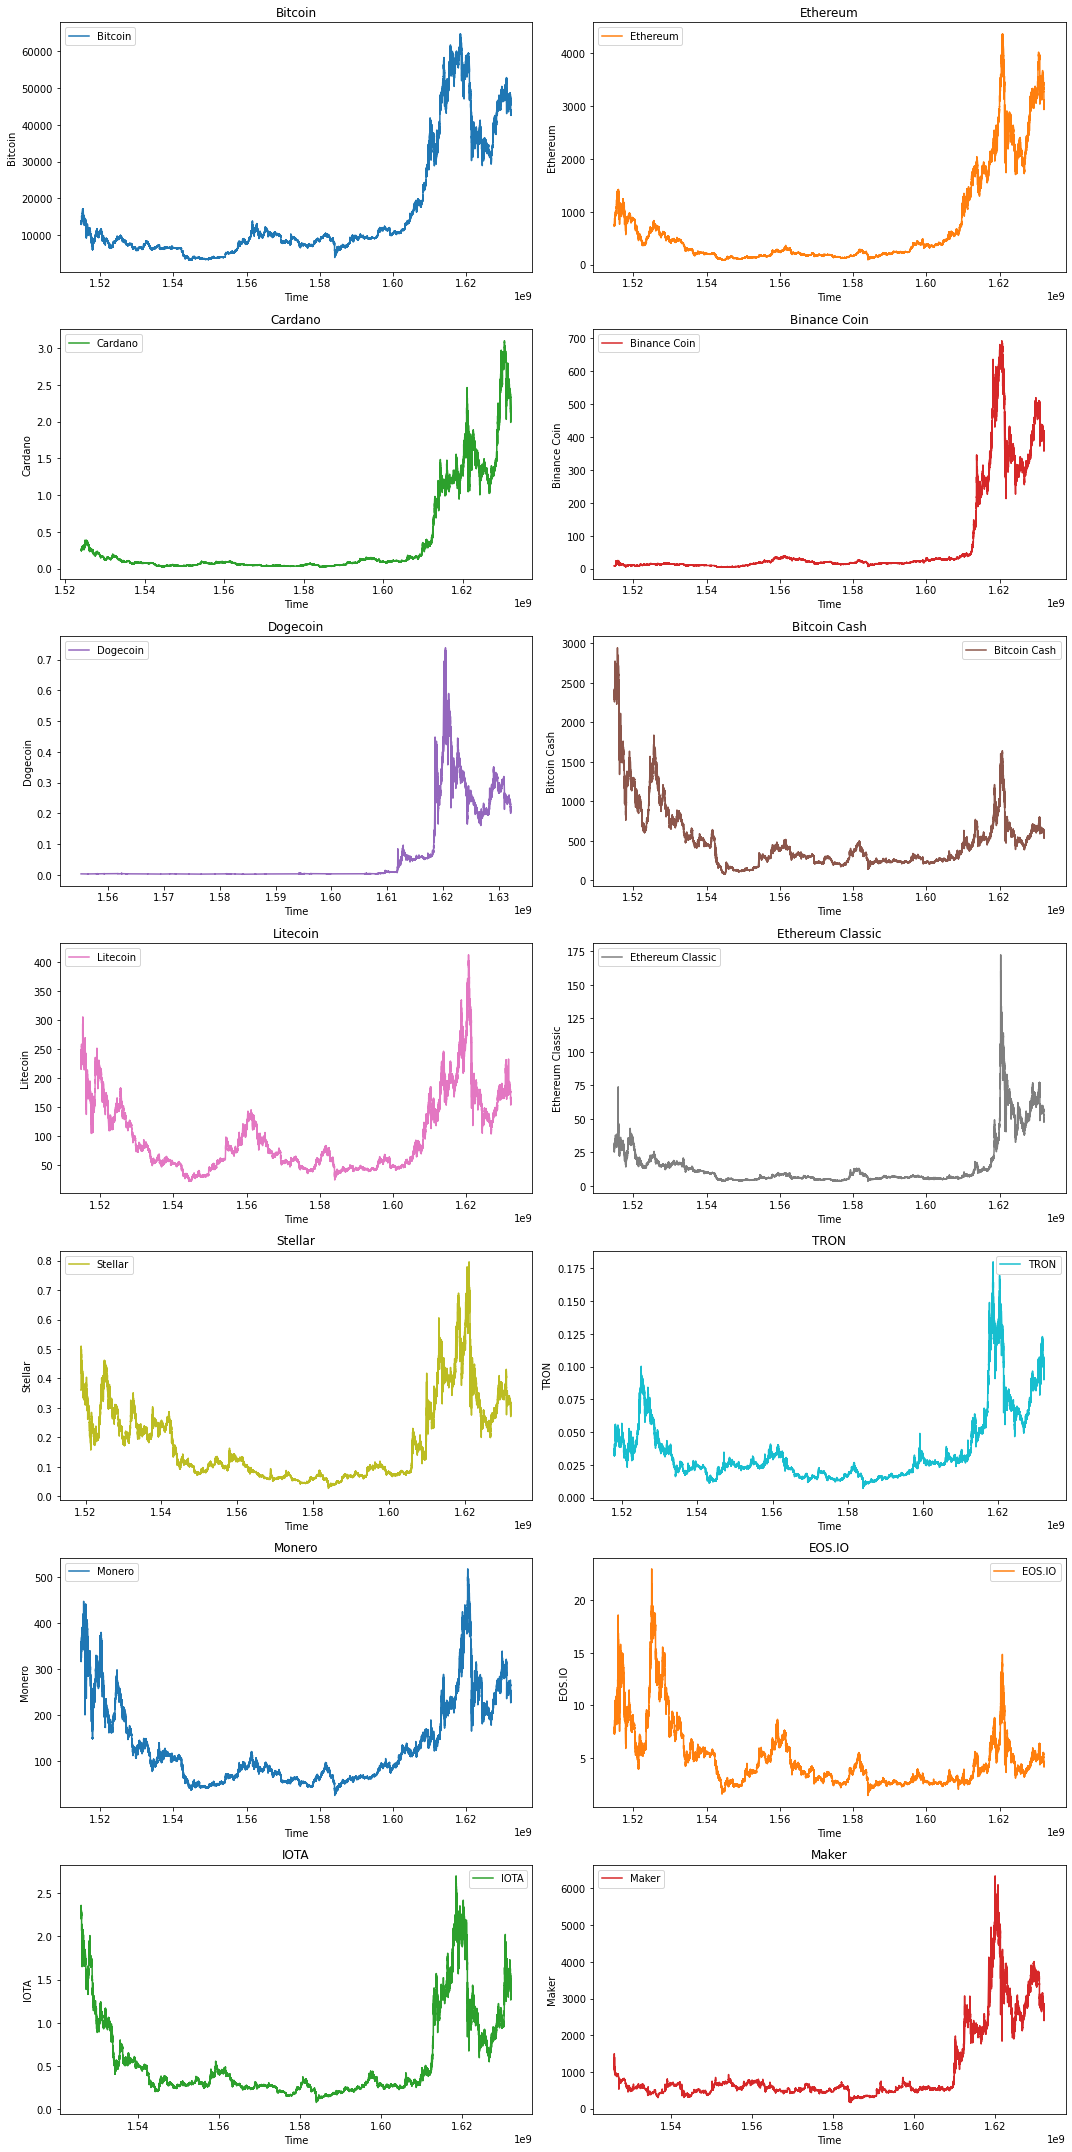

In [10]:
# plot close values as time series for all the assets
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

**Inference:**
* There seemse to be a good correlation between different crypto assets and also seems to vary in different timelines.
* We have got the bear data from 2018 timeline, bull data from 2021 timeline, sideways data from 2019 and 2020 timeline. So this dataset captures different types of market for us to model. 

Also different coins have different time lines in the above graph. So let us just take the data after July 1, 2021 and see the price movements of different assets.

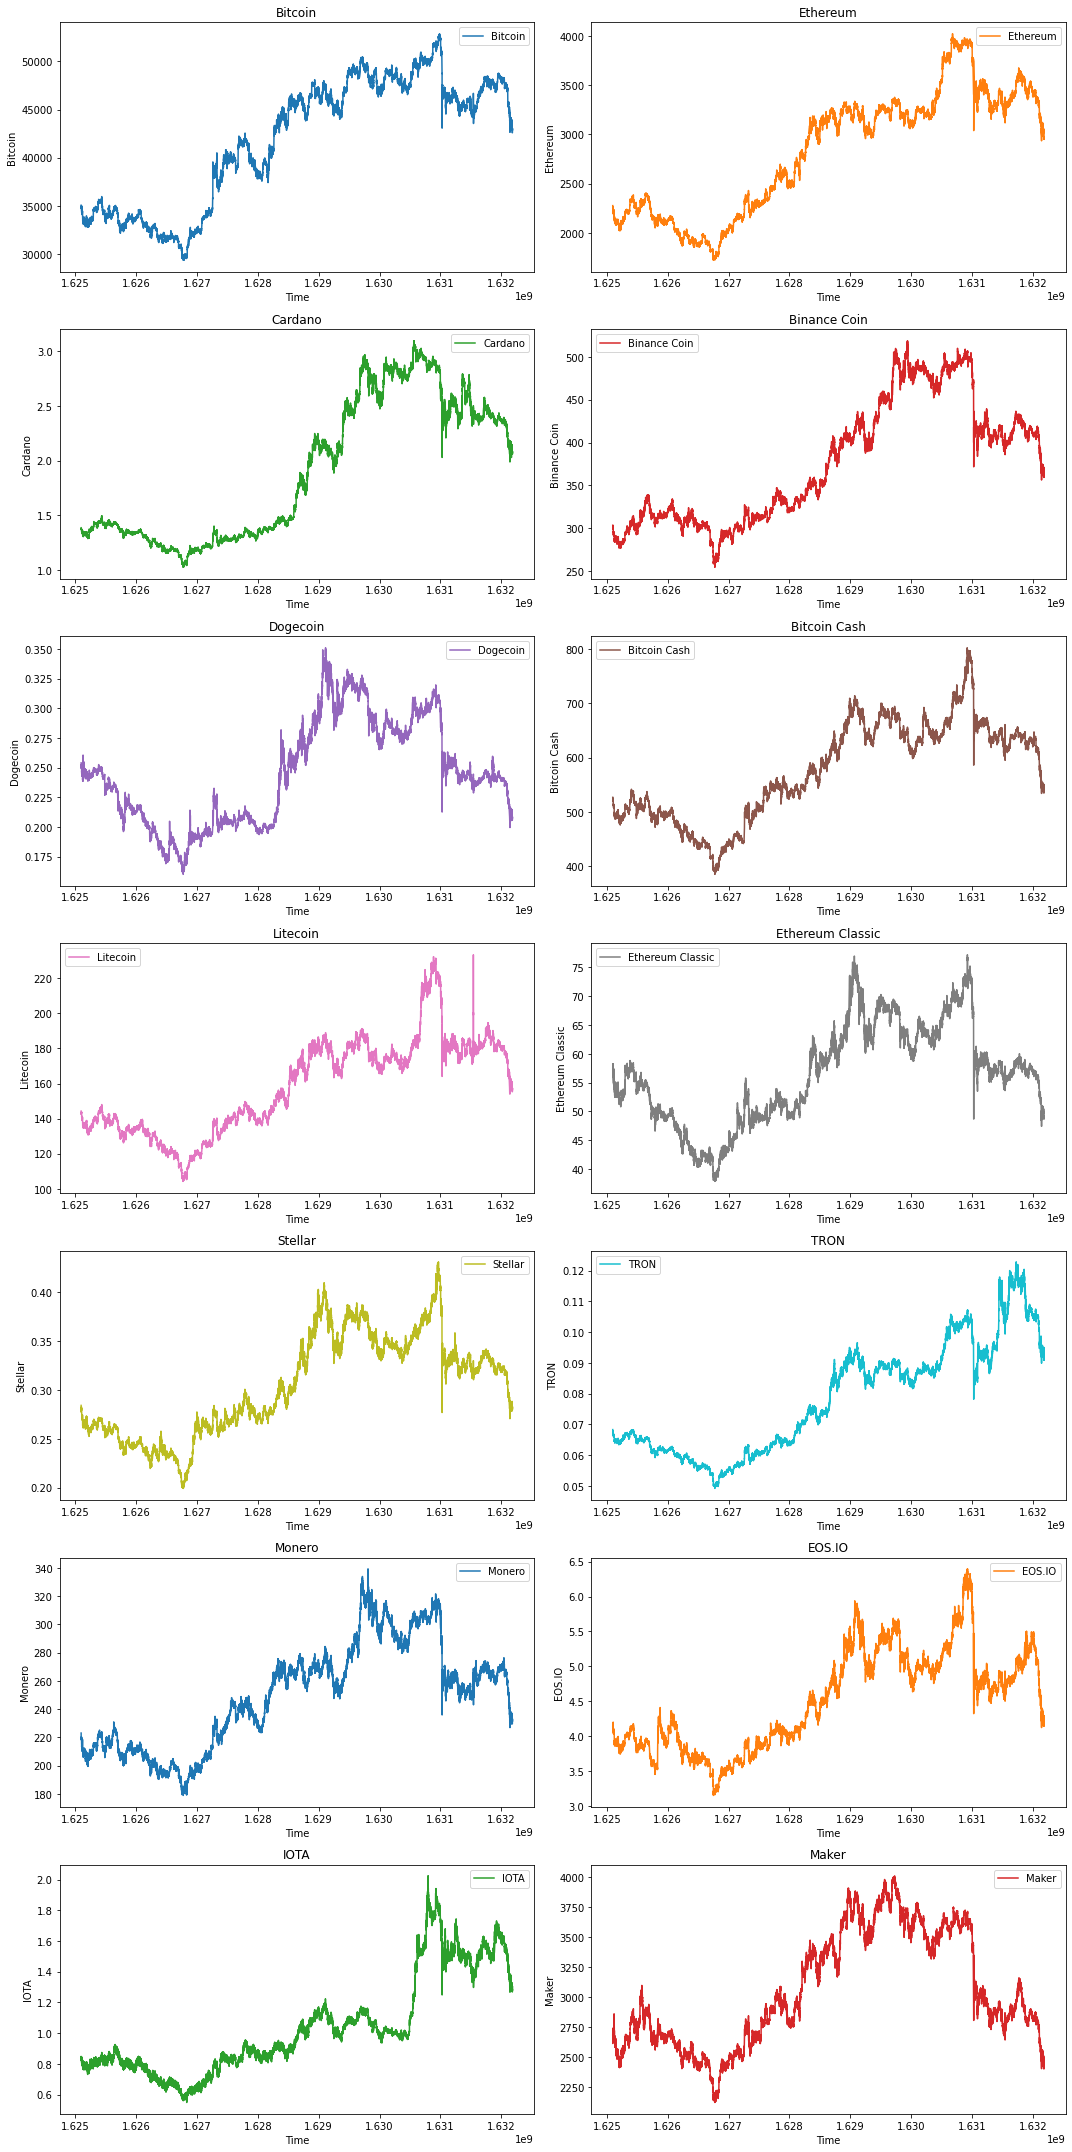

In [11]:
import time
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

## Correlation

### Correlation on actual price values

Let us create a correlation plot on the actual price values of these different assets for the latest time period (from July 1, 2021).

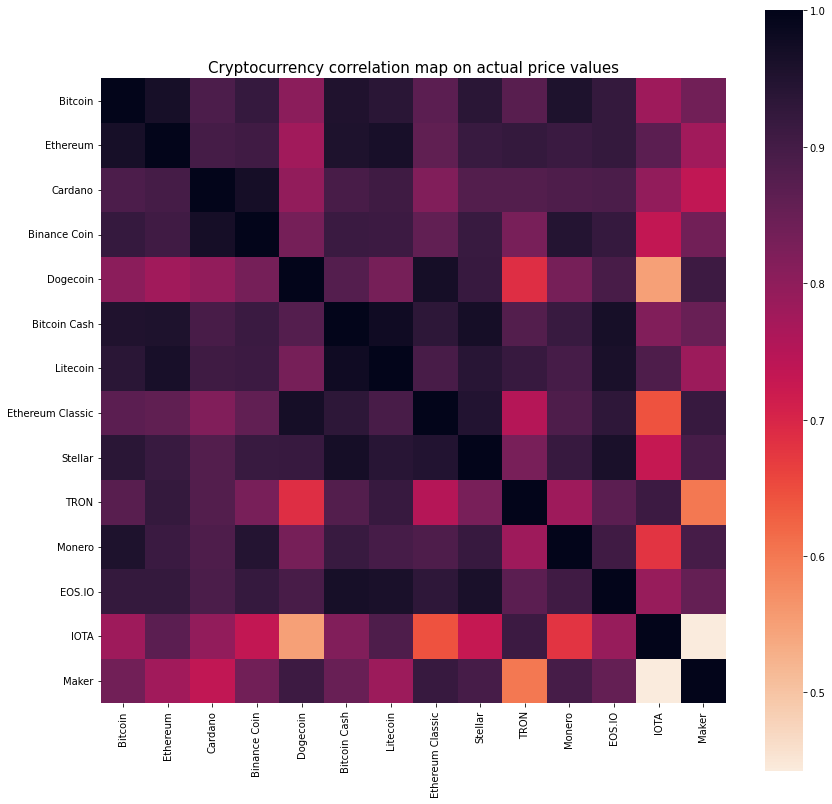

In [12]:
all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    close_values = coin_df["Close"].fillna(0)
    close_values.name = coin
    all_assets_df = all_assets_df.join(close_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Cryptocurrency correlation map on actual price values", fontsize=15)
plt.show()

**Inference:**
* We could clearly see the high correlation between different assets
* Lowest correlation itself is in the range of 0.4x
* There is a high correlation between
    * Bitcoin & Ethereum
    * Cardano & Binance coin
    * Bitcoin Cash & Litecoin
    
### Correlation on Log Returns

But we got the correlation on actual values. Different coins are in different price ranges. So let us use the `log returns` as suggested by the [tutorial notebook](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition) and check the correlation for the latest time period.

From the tutorial notebook, 

**Log returns**

In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [13]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

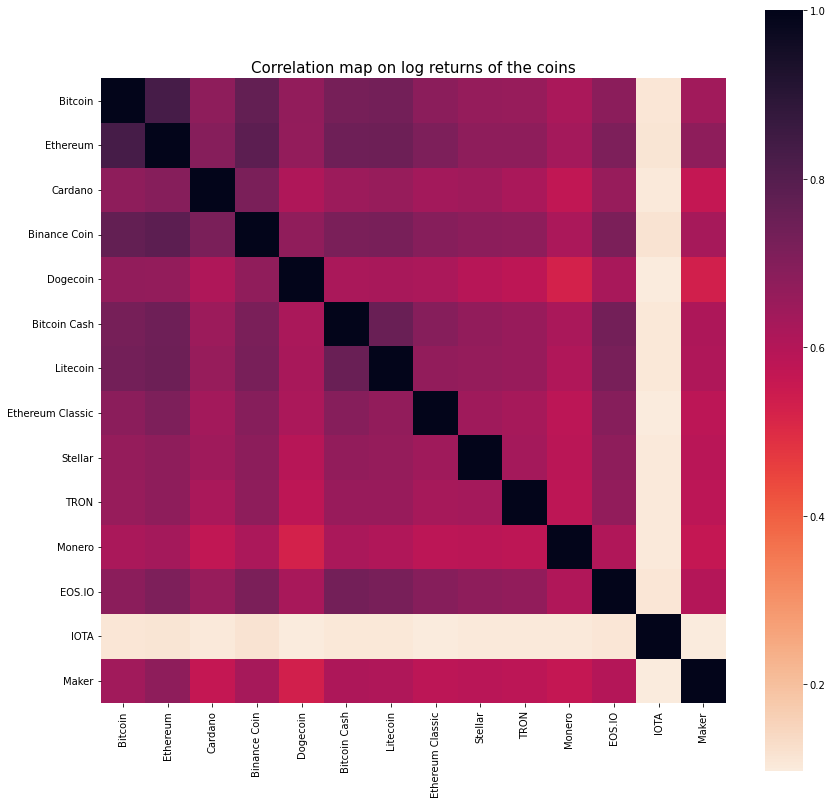

In [14]:
all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    return_values = log_return(coin_df["Close"].fillna(0))[1:]
    return_values.name = coin
    all_assets_df = all_assets_df.join(return_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Correlation map on log returns of the coins", fontsize=15)
plt.show()

**Inference:**
* In the recent months, when we look at the log returns, IOTA has a very low correlation with other coins
* Bitcoin and Ethereum still shows a high correlation.
* Looks like correlation between the assets change over time and so this needs to be addressed while building models

### Correlation change over time

Now let us see how the correlations have changed over time on the log returns. We can just look at the coins Bitcoin, Ethereum, Dogecoin and IOTA and see how the correlations have changed over time.

In [15]:
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

def get_plots(df, col1, col2):
    p = figure(plot_width=1000, plot_height=500, title=f"{col1} & {col2} - correlation distribution over time")
    p.line(df['timestamp'], df[col1], alpha=0.7)
    return p

main_tabs_list = []
for coin1 in ['Bitcoin', 'Ethereum', 'Dogecoin', 'IOTA']:
    tab_list = []
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin1]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    return1_values = log_return(coin_df["Close"].fillna(0))[1:]
    return1_values.name = coin1
    for coin2 in asset_names:
        if coin2 != coin1:
            coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin2]].set_index("timestamp")
            coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
            return2_values = log_return(coin_df["Close"].fillna(0))[1:]
            return2_values.name = coin2
            two_assets = pd.concat([return1_values, return2_values], axis=1)
            corr_time_df = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,coin1].loc[:,coin2].reset_index()
            p = get_plots(corr_time_df, coin1, coin2)
            tab = Panel(child=p, title=f"Corr:{coin1} & {coin2}")
            tab_list.append(tab)
    tabs = Tabs(tabs=tab_list)
    panel = Panel(child=tabs, title=coin1)
    main_tabs_list.append(panel)
            

tabs = Tabs(tabs=main_tabs_list)
show(tabs)

Loading BokehJS ...

**Inference:**
* We could clearly see that the correlations between the assets are changing over time
* We can see that the correlation between bitcoin and ethereum is volatile and is high for most time periods.
* If we look at the correlation of assets with IOTA, it is not as high as other pairs.
* Since we are looking at the residualized returns in this competition, correlation between the assets play an important role. 


### Reference

Thanks to all the below notebooks / discussions which served as references. Kindly upvote them too.

* [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

#### Notebook in progress. Please visit later for more updates.